In [1]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
from rasterio.features import shapes
from shapely.geometry import shape
import pandas as pd
import geopandas as gpd
from glob import glob
import os
import json

with open("/mnt/Inputs/coco_filtered_maxar.json") as f:
    coco = json.load(f)
files = pd.DataFrame(coco["images"])
files.file_name = "/mnt/retrolens/" + files.file_name
files

,id,file_name,width,height
0,2,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
1,3,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2,8,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
3,10,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
4,11,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
...,...,...,...,...
2889,10513,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2890,10515,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2891,10516,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800
2892,10517,/mnt/retrolens/training_tiles/MaxarImagery/Hig...,800,800


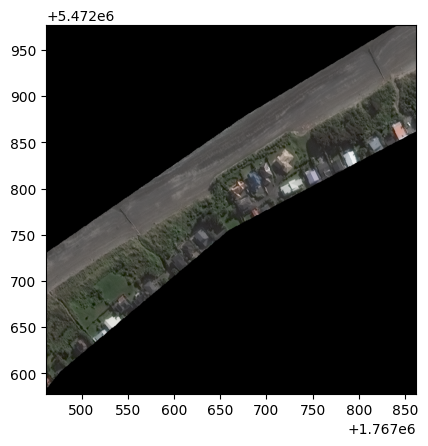

In [2]:
# Read a sample image
filename = files.file_name.sample(1).iloc[0]
image = rasterio.open(filename)
ax = rasterio.plot.show(image)

In [3]:
# Read the image data as a numpy array
image_data = rasterio.plot.reshape_as_image(image.read())

In [4]:
image.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 800, 'count': 3, 'crs': CRS.from_epsg(2193), 'transform': Affine(0.49998606013702357, 0.0, 1767461.6420914773,
       0.0, -0.49998606013702357, 5472977.588073029), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [5]:
# Check which parts of the image are black
black = image_data.sum(axis=2) == 0
black.sum() / len(black.flat)

0.6925171875

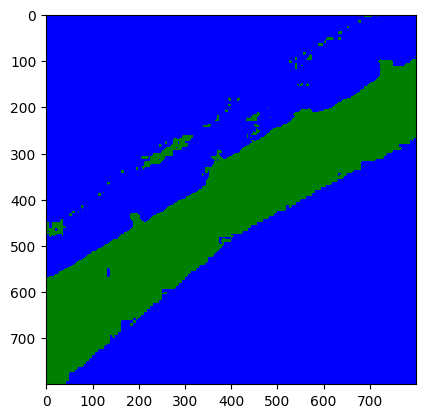

In [6]:
def predict(inp_image):

    model_path = '/mnt/output/land_bodies_model_long.onnx'
    inp_dim = inp_image.shape[:2]

    image = cv2.resize(inp_image, (256, 256))
    image = np.array(image, dtype=np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, axis=0)

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    pred_onx = session.run([output_name], {input_name: image.astype(np.float32)})[0]
    pred_onx = pred_onx > 0.5
    pred_onx = pred_onx * 255
    pred_onx = cv2.resize(pred_onx[0, 0].astype(np.uint8) , (inp_dim[1], inp_dim[0]))
    return pred_onx

mask = predict(image_data) / 255
#mask[black] = np.nan
cmap = matplotlib.colors.ListedColormap(['blue', 'green'])
plt.imshow(mask, cmap=cmap)

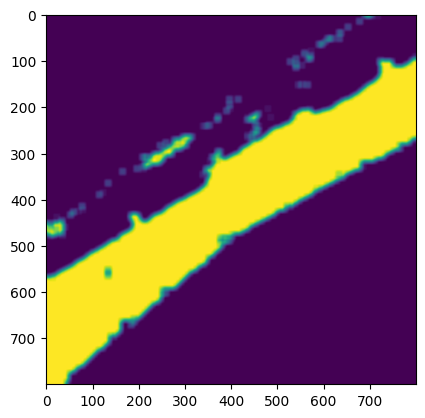

In [7]:
blur = cv2.GaussianBlur(mask, (15,15), sigmaX=15)
plt.imshow(blur)

In [8]:
shape_gen = ((shape(s), v) for s, v in shapes(blur.astype(np.uint8), mask=~black, transform=image.transform))
df = gpd.GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=image.crs)
df["area"] = df.area
df.sort_values(by="area")
df

,geometry,class,area
0,"POLYGON ((1767843.131 5472977.588, 1767861.631...",0.0,22162.514179
1,"POLYGON ((1767523.140 5472707.096, 1767523.140...",0.0,206.988458
2,"POLYGON ((1767861.131 5472925.090, 1767861.631...",1.0,26825.004190


<Axes: >

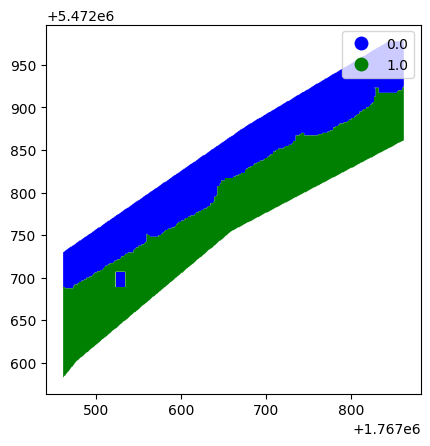

In [9]:
df.plot(column="class", categorical=True, cmap=cmap, legend=True)

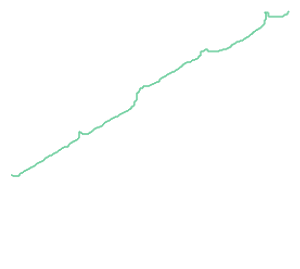

In [10]:
land_poly = df.geometry[df["class"] == 1].iloc[0]
sea_poly = df.geometry[df["class"] == 0].iloc[0]
line = land_poly.intersection(sea_poly)
line

<Axes: >

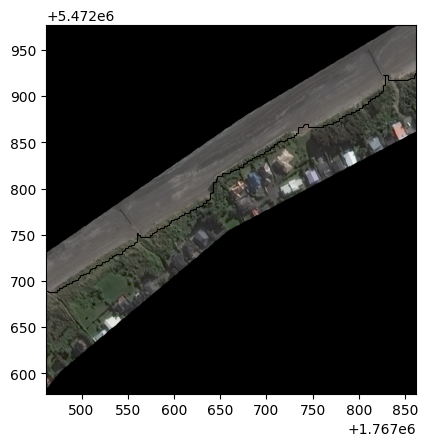

In [11]:
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)
line_df = gpd.GeoDataFrame(geometry=[line])
line_df.plot(color="black", linewidth=.8, ax=ax)

In [12]:
output_filename = "/mnt/output/shapefiles/" + os.path.splitext(os.path.basename(filename))[0] + ".shp"
output_filename

'/mnt/output/shapefiles/KapitiMid_25AUG2017_1767461_5472977.shp'

In [13]:
line_df.to_file(output_filename)